In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.metrics import accuracy_score


In [2]:

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + "\\general_python_scripts") #need to add folder "general_python_scripts" to path to be able to import following module
import data_cleaning_functions


In [15]:
df=pd.read_csv("train.csv").drop('id', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54607 entries, 0 to 54606
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   occ_code_level2   54607 non-null  int64  
 1   age               29892 non-null  float64
 2   stock_dividends   29720 non-null  float64
 3   mig_chg_msa       26888 non-null  object 
 4   tax_filer_stat    29121 non-null  object 
 5   det_hh_summ       54607 non-null  object 
 6   mig_prev_sunbelt  26888 non-null  object 
 7   hisp_origin       54377 non-null  object 
 8   education         29786 non-null  object 
 9   wage_per_hour     29712 non-null  float64
 10  capital_losses    29850 non-null  float64
 11  vet_question      54607 non-null  object 
 12  own_or_self       54607 non-null  int64  
 13  country_self      53532 non-null  object 
 14  mig_move_reg      26888 non-null  object 
 15  high_income       54607 non-null  int64  
 16  hs_college        29771 non-null  object

checking all rows containing NaN's

In [16]:
null_per_column = pd.DataFrame({ col : [df[col].isnull().sum().sum()] for col in df.columns if df[col].isnull().sum().sum()!=0}, index=['number_of_nan']).T.sort_values('number_of_nan')
null_per_column

,number_of_nan
state_prev_res,184
hisp_origin,230
country_self,1075
country_mother,1789
country_father,2026
weeks_worked,24197
sex,24534
age,24715
capital_losses,24757
education,24821


In [46]:
df_at_least_one_missing = df[df.isna().any(axis=1)]
df_at_least_one_missing

,occ_code_level2,age,stock_dividends,mig_chg_msa,tax_filer_stat,det_hh_summ,mig_prev_sunbelt,hisp_origin,education,wage_per_hour,...,marital_stat,region_prev_res,mig_chg_reg,country_father,occ_code_level1,full_or_part_emp,weeks_worked,det_hh_fam_stat,num_emp,vet_benefits
0,0,42.0,0.0,NaN,Nonfiler,Householder,NaN,All other,11th grade,0.0,...,NaN,Not in universe,NaN,United-States,Not in universe,Not in labor force,0.0,Householder,0,2
1,18,56.0,NaN,NaN,NaN,Householder,NaN,All other,High school graduate,0.0,...,Married-civilian spouse present,Not in universe,NaN,United-States,Sales,Full-time schedules,NaN,Householder,1,2
2,26,26.0,NaN,NaN,Joint both under 65,Householder,NaN,All other,High school graduate,0.0,...,NaN,Not in universe,NaN,Haiti,Adm support including clerical,Full-time schedules,NaN,Householder,3,2
3,0,67.0,NaN,MSA to MSA,Joint one under 65 & one 65+,Householder,No,All other,NaN,0.0,...,NaN,Northeast,Same county,United-States,Not in universe,Children or Armed Forces,0.0,Householder,0,1
4,0,NaN,NaN,Nonmover,Nonfiler,Child under 18 never married,Not in universe,All other,Children,0.0,...,NaN,Not in universe,Nonmover,United-States,Not in universe,Children or Armed Forces,NaN,Child <18 never marr not in subfamily,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54602,2,NaN,NaN,Nonmover,NaN,Householder,Not in universe,All other,NaN,0.0,...,Married-civilian spouse present,Not in universe,Nonmover,United-States,Executive admin and managerial,Children or Armed Forces,NaN,Householder,4,2
54603,0,32.0,0.0,NaN,Nonfiler,Householder,NaN,All other,High school graduate,NaN,...,NaN,Not in universe,NaN,United-States,Not in universe,Not in labor force,0.0,Nonfamily householder,0,2
54604,0,22.0,NaN,Nonmover,NaN,Child 18 or older,Not in universe,All other,Some college but no degree,0.0,...,Never married,Not in universe,Nonmover,United-States,Not in universe,Children or Armed Forces,12.0,Child 18+ never marr Not in a subfamily,1,2
54605,0,4.0,0.0,NaN,Nonfiler,Child under 18 never married,NaN,All other,Children,0.0,...,NaN,Not in universe,NaN,Trinadad&Tobago,Not in universe,Children or Armed Forces,0.0,Child <18 never marr not in subfamily,0,0


## Dealing with nan values

In [48]:
df_of_amount_of_nan = pd.DataFrame({col : [df_at_least_one_missing.loc[k].isna().sum() for k in df_at_least_one_missing.index]}, index = df_at_least_one_missing.index)
df_of_amount_of_nan.columns=['number_of_nan']
df_of_amount_of_nan.sort_values('number_of_nan')

,number_of_nan
17549,1
13881,1
41031,1
25151,1
13865,1
...,...
23668,19
6880,19
29977,19
25147,19


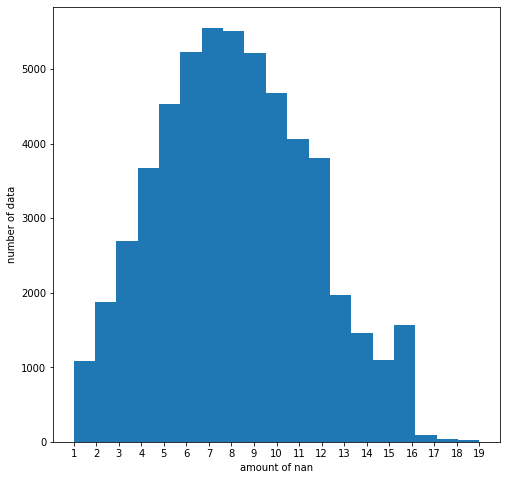

In [77]:
plt.figure(figsize=(8,8))
plt.xlabel('amount of nan')
plt.ylabel('number of data')
plt.xticks([k for k in range(20)])
plt.hist(df_of_amount_of_nan, 19);

In [72]:
threshold = 12
index_to_drop = df_of_amount_of_nan[df_of_amount_of_nan['number_of_nan'] > threshold].index
df = df.drop(index_to_drop, axis=0)

## dealing with categorical data

In [7]:
df_changed, categories = data_cleaning_functions.change_to_cat(df,threshold=2)

In [8]:
very_close_categories = categories

In [9]:
almost_duplicates = data_cleaning_functions.check_almost_duplicates(categories)

In [10]:
almost_duplicates

,mig_chg_msa,tax_filer_stat,det_hh_summ,mig_prev_sunbelt,hisp_origin,education,vet_question,country_self,mig_move_reg,high_income,...,citizenship,union_member,fam_under_18,marital_stat,region_prev_res,mig_chg_reg,country_father,occ_code_level1,full_or_part_emp,det_hh_fam_stat
9,NaN,None,None,None,NaN,Bachelors degree(BA AB BS),None,France,NaN,None,...,None,None,None,None,None,None,France,Private household services,None,Child <18 spouse of subfamily RP
10,None,None,None,None,None,Children,None,Germany,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,None,None,None,None,None,Doctorate degree(PhD EdD),None,Greece,None,None,...,None,None,None,None,None,None,Greece,Protective services,None,Grandchild 18+ ever marr RP of subfamily
12,None,None,None,None,None,High school graduate,None,Guatemala,None,None,...,None,None,None,None,None,None,Guatemala,Sales,None,Grandchild 18+ ever marr not in subfamily
13,None,None,None,None,None,Less than 1st grade,None,Haiti,None,None,...,None,None,None,None,None,None,Haiti,Technicians and related support,None,Grandchild 18+ never marr RP of subfamily
14,None,None,None,None,None,Masters degree(MA MS MEng MEd MSW MBA),None,Holand-Netherlands,None,None,...,None,None,None,None,None,None,Holand-Netherlands,Transportation and material moving,None,Grandchild 18+ never marr not in subfamily
15,None,None,None,None,None,Prof school degree (MD DDS DVM LLB JD),None,Honduras,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,None,None,None,None,None,Some college but no degree,None,Hong Kong,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,None,None,None,None,None,NaN,None,Hungary,None,None,...,None,None,None,None,None,None,Hungary,None,None,Grandchild <18 never marr not in subfamily
18,None,None,None,None,None,None,None,India,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
